# DL w/CV
* [Source for this notebook](https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/)
* [TIME SERIES FORCASTING WITH TENSORFLOW FROM THE AUTHORS!](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error as mse
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, RepeatVector
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation
from keras.optimizers import Adam
from helper import ( prepare_data, train_test_shuffle_split, train_test_seq_split, print_folds_stats )

from matplotlib import pyplot as plt
plt.style.use('ggplot')     # 'fivethirtyeight'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mse = tf.keras.losses.MeanSquaredError()
#mae = tf.keras.losses.MeanAbsoluteError()
#mape = tf.keras.losses.MeanAbsolutePercentageError()
#msle = tf.keras.losses.MeanSquaredLogarithmicError()        # square(log(y_true + 1.) - log(y_pred + 1.))
#cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)      # reduction=tf.keras.losses.Reduction.SUM ?

## Prepare
If the number of features is more than one

In [3]:
df = pd.read_csv( 'data/2step_20210329.csv', encoding='utf-8' )
print('Shape of loaded data:', df.shape, '\n')

n_steps      = 4
random_state = 34
features     = ['num1', 'num2', 'num3', 'num4']
n_features   = len(features)

( X,
  y,
  goldenx,
  goldeny )  = prepare_data( df,
                             features,
                             n_steps,
                             with_intersection=True,
                             flatten=False )

tscv = TimeSeriesSplit( n_splits=5, max_train_size=int( len(X)*0.8 ) )                    # no random_state

X_sh, y_sh = deepcopy(X), deepcopy(y)
X_sh, y_sh = shuffle( X_sh, y_sh, random_state=random_state, n_samples=None )
kf = KFold( n_splits=5, shuffle=True, random_state=random_state )

print_folds_stats( X, X_sh, tscv, kf )

Shape of loaded data: (2073, 8) 

Dropping 1 last row for golden data point
Data prepared:
	Size of X = (2068 by 4)
	Size of y = (2068 by 4)

TimeSeriesSplit indices:
(Train, test): (348, 344)
(Train, test): (692, 344)
(Train, test): (1036, 344)
(Train, test): (1380, 344)
(Train, test): (1654, 344)

KFold indices:
(Train, test): (1654, 414)
(Train, test): (1654, 414)
(Train, test): (1654, 414)
(Train, test): (1655, 413)
(Train, test): (1655, 413)


## Hyperparameter Grid Search

TRY 1 BiLSTM LAYER, DROPOUT() AS A SEPARATE LAYER  
metrics = [ 'mse', 'mae', 'mape', 'msle', 'cosine_similarity' ]  
do not use sigmoid or tanh!

In [4]:
def stacked_BiLSTM( n_steps, n_features,
                    learning_rate=0.005,
                    units=750,
                    activation='relu',
                    dropout1=0,
                    dropout2=0,
                    dropout3=0,
                    optimizer='adam',
                    loss=mse,
                    print_architecture=False ):
    
    model = Sequential()
    model.add( Bidirectional( LSTM( units, activation=activation,
                                    dropout=dropout1,
                                    recurrent_dropout=dropout2,
                                    return_sequences=True),
                                                          
                              input_shape=(n_steps, n_features)
                            )
             )
        
    model.add( Bidirectional( LSTM( units, activation=activation ) ) )
    model.add(Dropout( dropout3 ))
    model.add( Dense( n_features ) )
    
    # 'mse', mae', 'mape', 'msle', 'cosine_similarity'
    model.compile( optimizer=Adam(lr=learning_rate),
                   loss=loss,
                   metrics=[tf.keras.metrics.LogCoshError()] )     # metrics=['mse'], optimizer=Adam(lr=learning_rate)
        
    if print_architecture:
        print(model.summary())
        
    return model

In [5]:
# PRINT AS AN EXAMPLE
model = stacked_BiLSTM( n_steps, n_features, print_architecture=True )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4, 1500)           4530000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1500)              13506000  
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6004      
Total params: 18,042,004
Trainable params: 18,042,004
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
def run_cv( X_, y_, cv_folds, ts_flag=False, dropout=0.15, batch_size=32, epochs=6 ):
        
    print( f'Stacked_BiLSTM, dropout2 {dropout}, cv method {cv_folds.__str__()}' )
    print( f'                batch_size {batch_size}, num epochs {epochs}')
    verbose = 0
    score_per_fold, loss_per_fold = [], []

    fold_no = 1
    for train_idx, test_idx in cv_folds.split( X_ ):

        # Define and compile model
        model = stacked_BiLSTM( n_steps, n_features, dropout2=dropout )

        print('\n', '='*100, '\n', sep='')
        print('Training in fold {} ...'.format( fold_no ))

        # Fit data to model
        if ts_flag:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=False,
                                 verbose=verbose )
        else:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=verbose )

        # Generate metrics
        scores = model.evaluate( X_[test_idx], y_[test_idx], verbose=verbose )
        print(f'Score in fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        score_per_fold.append( scores[1] )
        loss_per_fold.append(  scores[0] )

        # Increase fold number
        fold_no = fold_no + 1
        
    # Average scores
    average_loss  = round( np.mean(loss_per_fold), 4 )
    average_std   = round( np.std(loss_per_fold), 4 )
    average_score = round( np.mean(score_per_fold), 4)
    print( '\n', '='*100, sep='' )
    print( f'Average metrics for the run with dropout2 {dropout}, cv method {cv_folds.__str__()}, batch_size {batch_size} and number of epochs {epochs}')
    print('Per fold:')
    print( '{:>10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('', 1, 2, 3, 4, 5) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Loss',  *[ round(i, 4) for i in loss_per_fold  ] ) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Score', *[ round(i, 4) for i in score_per_fold ] ) )
    print( '='*100 )
    print(f'Average loss:  {average_loss}  +-{average_std}')
    print(f'Average score: {average_score}')
    print( '='*100 )
    
    return average_loss, average_std, average_score

In [9]:
metrics = []
cv_engines = [ kf, tscv ]
drpt_list = [ 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7 ]
for cv_engine in cv_engines:
    for dropout in drpt_list:
        
        ts_flag = 'TimeSeriesSplit' in cv_engine.__str__()
        if ts_flag:
            loss, std, score = run_cv( X, y, cv_engine, ts_flag, dropout=dropout)
        else:
            loss, std, score = run_cv( X_sh, y_sh, cv_engine, ts_flag, dropout=dropout)
                        
        metrics.append(( loss, score, dropout, cv_engine.__str__() ))
        print('metrics =', metrics)

Stacked_BiLSTM, dropout2 0, cv method KFold(n_splits=5, random_state=34, shuffle=True)
                batch_size 32, num epochs 6


Training in fold 1 ...
Score in fold 1: loss of 106.55168914794922; logcosh of 8.280599594116211


Training in fold 2 ...
Score in fold 2: loss of 102.69500732421875; logcosh of 8.040163040161133


Training in fold 3 ...
Score in fold 3: loss of 104.0307846069336; logcosh of 8.16988754272461


Training in fold 4 ...
Score in fold 4: loss of 107.66056060791016; logcosh of 8.276382446289062


Training in fold 5 ...
Score in fold 5: loss of 101.78812408447266; logcosh of 8.043107032775879

Average metrics for the run with dropout2 0, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       106.5517  102.695   104.0308  107.6606  101.7881 
Score       8.2806    8.0402    8.1699    8.2764    8.0431  
Average loss:  104.5452  +-2.237
Average



Training in fold 1 ...
Score in fold 1: loss of 112.94358825683594; logcosh of 8.469673156738281


Training in fold 2 ...
Score in fold 2: loss of 104.94447326660156; logcosh of 8.10914134979248


Training in fold 3 ...
Score in fold 3: loss of 104.78614807128906; logcosh of 8.196285247802734


Training in fold 4 ...
Score in fold 4: loss of 106.52212524414062; logcosh of 8.246725082397461


Training in fold 5 ...
Score in fold 5: loss of 105.6825180053711; logcosh of 8.157731056213379

Average metrics for the run with dropout2 0.2, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       112.9436  104.9445  104.7861  106.5221  105.6825 
Score       8.4697    8.1091    8.1963    8.2467    8.1577  
Average loss:  106.9758  +-3.0468
Average score: 8.2359
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFo



Training in fold 1 ...
Score in fold 1: loss of 121.13182830810547; logcosh of 8.698214530944824


Training in fold 2 ...
Score in fold 2: loss of 104.8266372680664; logcosh of 8.137709617614746


Training in fold 3 ...
Score in fold 3: loss of 105.01180267333984; logcosh of 8.20745849609375


Training in fold 4 ...
Score in fold 4: loss of 107.20008087158203; logcosh of 8.295973777770996


Training in fold 5 ...
Score in fold 5: loss of 116.3699951171875; logcosh of 8.527131080627441

Average metrics for the run with dropout2 0.4, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       121.1318  104.8266  105.0118  107.2001   116.37  
Score       8.6982    8.1377    8.2075    8.296     8.5271  
Average loss:  110.9081  +-6.6311
Average score: 8.3733
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 3 ...
Score in fold 3: loss of 104.77482604980469; logcosh of 8.1881685256958


Training in fold 4 ...
Score in fold 4: loss of 105.93824768066406; logcosh of 8.247111320495605


Training in fold 5 ...
Score in fold 5: loss of 103.96855163574219; logcosh of 8.111684799194336

Average metrics for the run with dropout2 0.55, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       107.2397  103.7718  104.7748  105.9382  103.9686 
Score       8.2928    8.0888    8.1882    8.2471    8.1117  
Average loss:  105.1386  +-1.298
Average score: 8.1857
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.5248, 8.202, 0.1, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.6055, 8.2316, 0.15, 'KFold(n_splits=5, random_state=34, shuffle=True

Score in fold 1: loss of 105.27674102783203; logcosh of 8.243785858154297


Training in fold 2 ...
Score in fold 2: loss of 104.1755142211914; logcosh of 8.121256828308105


Training in fold 3 ...
Score in fold 3: loss of 102.87623596191406; logcosh of 8.137253761291504


Training in fold 4 ...
Score in fold 4: loss of 108.15128326416016; logcosh of 8.323395729064941


Training in fold 5 ...
Score in fold 5: loss of 107.95166015625; logcosh of 8.264225959777832

Average metrics for the run with dropout2 0.7, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       105.2767  104.1755  102.8762  108.1513  107.9517 
Score       8.2438    8.1213    8.1373    8.3234    8.2642  
Average loss:  105.6863  +-2.0763
Average score: 8.218
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=



Training in fold 1 ...
Score in fold 1: loss of 111.33051300048828; logcosh of 8.41871452331543


Training in fold 2 ...
Score in fold 2: loss of 104.37269592285156; logcosh of 8.149977684020996


Training in fold 3 ...
Score in fold 3: loss of 103.79759216308594; logcosh of 8.127901077270508


Training in fold 4 ...
Score in fold 4: loss of 108.43561553955078; logcosh of 8.339849472045898


Training in fold 5 ...
Score in fold 5: loss of 105.15776824951172; logcosh of 8.183481216430664

Average metrics for the run with dropout2 0.1, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.3305  104.3727  103.7976  108.4356  105.1578 
Score       8.4187     8.15     8.1279    8.3398    8.1835  
Average loss:  106.6188  +-2.851
Average score: 8.244
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 1 ...
Score in fold 1: loss of 111.46656036376953; logcosh of 8.370567321777344


Training in fold 2 ...
Score in fold 2: loss of 106.68963623046875; logcosh of 8.217764854431152


Training in fold 3 ...
Score in fold 3: loss of 102.3837890625; logcosh of 8.074373245239258


Training in fold 4 ...
Score in fold 4: loss of 108.65922546386719; logcosh of 8.34700870513916


Training in fold 5 ...
Score in fold 5: loss of 104.73695373535156; logcosh of 8.160039901733398

Average metrics for the run with dropout2 0.25, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.4666  106.6896  102.3838  108.6592  104.737  
Score       8.3706    8.2178    8.0744    8.347      8.16   
Average loss:  106.7872  +-3.1306
Average score: 8.234
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(



Training in fold 1 ...
Score in fold 1: loss of 111.61451721191406; logcosh of 8.427902221679688


Training in fold 2 ...
Score in fold 2: loss of 106.03932189941406; logcosh of 8.212669372558594


Training in fold 3 ...
Score in fold 3: loss of 103.44519805908203; logcosh of 8.118642807006836


Training in fold 4 ...
Score in fold 4: loss of 106.6817398071289; logcosh of 8.278470039367676


Training in fold 5 ...
Score in fold 5: loss of 104.50023651123047; logcosh of 8.1581392288208

Average metrics for the run with dropout2 0.4, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.6145  106.0393  103.4452  106.6817  104.5002 
Score       8.4279    8.2127    8.1186    8.2785    8.1581  
Average loss:  106.4562  +-2.8187
Average score: 8.2392
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 5 ...
Score in fold 5: loss of 105.2088623046875; logcosh of 8.186064720153809

Average metrics for the run with dropout2 0.5, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       109.2312   108.47   101.6906  106.7302  105.2089 
Score       8.3371    8.2688    8.0372    8.2799    8.1861  
Average loss:  106.2662  +-2.6802
Average score: 8.2218
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.5248, 8.202, 0.1, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.6055, 8.2316, 0.15, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.9758, 8.2359, 0.2, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.0289, 8.1885, 0.25, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.3018, 8.1628, 0.3, 'KFold(n_spli



Training in fold 1 ...
Score in fold 1: loss of 110.04083251953125; logcosh of 8.401792526245117


Training in fold 2 ...
Score in fold 2: loss of 104.72976684570312; logcosh of 8.158445358276367


Training in fold 3 ...
Score in fold 3: loss of 102.07359313964844; logcosh of 8.056126594543457


Training in fold 4 ...
Score in fold 4: loss of 107.82266235351562; logcosh of 8.308663368225098


Training in fold 5 ...
Score in fold 5: loss of 104.72434997558594; logcosh of 8.17288875579834

Average metrics for the run with dropout2 0.65, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       110.0408  104.7298  102.0736  107.8227  104.7243 
Score       8.4018    8.1584    8.0561    8.3087    8.1729  
Average loss:  105.8782  +-2.7653
Average score: 8.2196
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'K

In [10]:
metrics

[(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (105.5248, 8.202, 0.1, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (106.6055, 8.2316, 0.15, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (106.9758, 8.2359, 0.2, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (105.0289, 8.1885, 0.25, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (104.3018, 8.1628, 0.3, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (105.3817, 8.1941, 0.35, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (110.9081, 8.3733, 0.4, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (106.2181, 8.2111, 0.45, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (104.7653, 8.176, 0.5, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (105.1386, 8.1857, 0.55, 'KFold(n_splits=5, random_state=34, shuffle=True)'),
 (104.5072, 8.1729, 0.6, 'KFold(n_splits=5, random_state=34, shu

In [23]:
# PREDICT ON GOLDEN DATA POINT
def predict_one(model, X_last, loss_func=mse):
       
    X_last = X_last.reshape((1, n_steps, n_features))
    pred = model.predict(X_last, verbose=0)
    return np.round( pred[0] )


use_tscv   = True
batch_size = 32
epochs     = 15
verbose    = 1

# train
model = stacked_BiLSTM( n_steps, n_features,
                        dropout1 = 0,
                        dropout2 = 0,
                        dropout3 = 0.15)
if use_tscv:
    history = model.fit( X, y,
                         batch_size=batch_size,
                         epochs=epochs,
                         shuffle=False,
                         verbose=verbose )
else:
    history = model.fit( X_sh, y_sh,
                         batch_size=batch_size,
                         epochs=epochs,
                         shuffle=True,
                         verbose=verbose )
    
# predict
print('Results on the last reserved data point:')
print('True:     ', goldeny)
print('Predicted:', predict_one( model, goldenx ))

Epoch 1/15
65/65 [==============================] - 12s 192ms/step - loss: 42899.6641 - logcosh: 34.6581
Epoch 2/15
65/65 [==============================] - 13s 196ms/step - loss: 108.0683 - logcosh: 8.2658
Epoch 3/15
65/65 [==============================] - 13s 207ms/step - loss: 106.7323 - logcosh: 8.2381
Epoch 4/15
65/65 [==============================] - 14s 214ms/step - loss: 107.1601 - logcosh: 8.2435
Epoch 5/15
65/65 [==============================] - 14s 223ms/step - loss: 105.8404 - logcosh: 8.2072
Epoch 6/15
65/65 [==============================] - 14s 213ms/step - loss: 105.8581 - logcosh: 8.2014
Epoch 7/15
65/65 [==============================] - 14s 212ms/step - loss: 105.4855 - logcosh: 8.1814
Epoch 8/15
65/65 [==============================] - 14s 212ms/step - loss: 105.8206 - logcosh: 8.1968
Epoch 9/15
65/65 [==============================] - 14s 215ms/step - loss: 105.4652 - logcosh: 8.1899
Epoch 10/15
65/65 [==============================] - 14s 209ms/step - loss: 106

In [24]:
# PREDICT ON TRAIN SET
def predict_train( model, X_, y_ ):
    
    for feature_set, target in zip( X_, y_ ):
        print('True:     ', target)
        print('Predicted:', predict_one( model, feature_set ))
        print('='*25)
        
predict_train( model, X_sh, y_sh )

True:      [18 17  7 15]
Predicted: [18. 17. 18. 19.]
True:      [30 23 33  5]
Predicted: [17. 17. 18. 19.]
True:      [21 13 22  4]
Predicted: [17. 17. 18. 18.]
True:      [12 14  3 24]
Predicted: [18. 18. 18. 20.]
True:      [34 11 21 33]
Predicted: [18. 17. 17. 19.]
True:      [31  7 25 35]
Predicted: [20. 20. 19. 22.]
True:      [ 4 22 33  6]
Predicted: [17. 16. 17. 18.]
True:      [11 19 27 30]
Predicted: [17. 17. 17. 19.]
True:      [30  4 32 13]
Predicted: [17. 17. 17. 19.]
True:      [27  8  9 31]
Predicted: [17. 17. 17. 19.]
True:      [ 7 10 22 16]
Predicted: [17. 17. 18. 19.]
True:      [ 7 16 26  1]
Predicted: [17. 17. 17. 19.]
True:      [25  8 32 15]
Predicted: [19. 18. 18. 20.]
True:      [ 7 32 21  9]
Predicted: [18. 18. 18. 20.]
True:      [21 16 15 35]
Predicted: [19. 20. 19. 21.]
True:      [16 31 30  1]
Predicted: [19. 18. 18. 20.]
True:      [25 11 31 26]
Predicted: [18. 18. 18. 19.]
True:      [32 21 27 30]
Predicted: [18. 18. 18. 19.]
True:      [34 29 20  9]
Pre

Predicted: [18. 17. 17. 19.]
True:      [ 4  7 30 16]
Predicted: [17. 17. 17. 19.]
True:      [26 22 17 33]
Predicted: [18. 18. 17. 19.]
True:      [ 6 32  3  5]
Predicted: [17. 17. 17. 19.]
True:      [19  9 18 33]
Predicted: [19. 19. 18. 20.]
True:      [21 26 25  8]
Predicted: [18. 18. 18. 20.]
True:      [ 8 13 23 30]
Predicted: [19. 19. 19. 20.]
True:      [24  3 23 11]
Predicted: [17. 17. 17. 19.]
True:      [32  3 11 33]
Predicted: [17. 17. 18. 19.]
True:      [ 4  1 34 13]
Predicted: [17. 17. 18. 19.]
True:      [21 34 25 19]
Predicted: [17. 17. 18. 19.]
True:      [ 3  8 17 27]
Predicted: [18. 17. 17. 20.]
True:      [12 35  5  6]
Predicted: [17. 17. 17. 18.]
True:      [33 30  9 15]
Predicted: [17. 17. 18. 19.]
True:      [29 26 25 27]
Predicted: [19. 18. 18. 20.]
True:      [ 6 21 22 13]
Predicted: [17. 17. 18. 19.]
True:      [ 2  8 13 31]
Predicted: [18. 18. 18. 20.]
True:      [16  4 17 33]
Predicted: [17. 17. 18. 19.]
True:      [22 17  7 14]
Predicted: [17. 17. 17. 19.]

Predicted: [17. 17. 17. 19.]
True:      [21 19 18  9]
Predicted: [17. 17. 17. 19.]
True:      [ 2 12 13 14]
Predicted: [16. 17. 17. 18.]
True:      [31 29  8 14]
Predicted: [19. 18. 19. 21.]
True:      [ 3  5 12 17]
Predicted: [16. 16. 17. 18.]
True:      [20 33 31 13]
Predicted: [18. 18. 19. 20.]
True:      [ 7 31  9 30]
Predicted: [18. 18. 19. 20.]
True:      [14 27 22  4]
Predicted: [18. 18. 19. 19.]
True:      [20 19 35 31]
Predicted: [17. 17. 17. 19.]
True:      [10 11 25  3]
Predicted: [18. 17. 17. 19.]
True:      [35 34  3 25]
Predicted: [19. 18. 18. 20.]
True:      [12  2 20 27]
Predicted: [18. 17. 18. 19.]
True:      [21 26 11  1]
Predicted: [19. 18. 18. 21.]
True:      [29 33 13  3]
Predicted: [18. 17. 18. 19.]
True:      [ 4 31  8  1]
Predicted: [17. 17. 17. 19.]
True:      [12  1  4 11]
Predicted: [17. 17. 17. 18.]
True:      [29 19 10  2]
Predicted: [17. 17. 18. 19.]
True:      [ 1 23  8 15]
Predicted: [17. 16. 17. 19.]
True:      [21 31 11 15]
Predicted: [18. 19. 18. 20.]

Predicted: [18. 18. 17. 19.]
True:      [29  5 15  4]
Predicted: [18. 18. 18. 20.]
True:      [ 5 23  7 29]
Predicted: [18. 18. 18. 19.]
True:      [22  5 34 20]
Predicted: [18. 18. 18. 20.]
True:      [ 7 18 12 26]
Predicted: [17. 17. 17. 19.]
True:      [ 6  7 33 19]
Predicted: [18. 18. 18. 20.]
True:      [31 29 27  8]
Predicted: [18. 18. 18. 19.]
True:      [ 3  6 34 20]
Predicted: [17. 16. 17. 18.]
True:      [ 4 32  6 25]
Predicted: [18. 18. 18. 19.]
True:      [19 12 22 28]
Predicted: [18. 18. 18. 20.]
True:      [23 27 32 14]
Predicted: [18. 18. 18. 19.]
True:      [ 1 25 30  8]
Predicted: [18. 18. 18. 19.]
True:      [ 7 31 17 10]
Predicted: [17. 17. 17. 19.]
True:      [ 4 31 11  6]
Predicted: [17. 17. 18. 19.]
True:      [ 5 34 29 28]
Predicted: [19. 18. 18. 21.]
True:      [29 26 10  1]
Predicted: [18. 17. 17. 20.]
True:      [12  8  9 35]
Predicted: [18. 18. 18. 20.]
True:      [29  1 10 27]
Predicted: [18. 18. 18. 20.]
True:      [26 17 27 22]
Predicted: [17. 17. 18. 18.]

Predicted: [18. 17. 18. 19.]
True:      [34 18 20 35]
Predicted: [18. 17. 19. 20.]
True:      [24 18 15  5]
Predicted: [17. 17. 18. 19.]
True:      [30 16 32 17]
Predicted: [17. 17. 17. 19.]
True:      [19 32 23 30]
Predicted: [18. 18. 18. 20.]
True:      [ 2 15 21 32]
Predicted: [17. 17. 17. 19.]
True:      [22  6 32 27]
Predicted: [19. 18. 18. 21.]
True:      [33 31 11 21]
Predicted: [18. 17. 18. 19.]
True:      [ 5 12 18  8]
Predicted: [18. 18. 18. 20.]
True:      [34 10 25 28]
Predicted: [20. 19. 19. 22.]
True:      [20 31  4  7]
Predicted: [17. 17. 17. 19.]
True:      [ 8 22 10 34]
Predicted: [18. 18. 18. 20.]
True:      [18 13  4 35]
Predicted: [18. 18. 18. 20.]
True:      [35 14 23 27]
Predicted: [18. 18. 18. 20.]
True:      [16  4  2 13]
Predicted: [17. 17. 17. 19.]
True:      [ 7 26 29 13]
Predicted: [17. 17. 17. 19.]
True:      [27  3 14  4]
Predicted: [17. 17. 17. 19.]
True:      [15 29 16  8]
Predicted: [17. 17. 17. 19.]
True:      [14  5  6 17]
Predicted: [18. 18. 18. 20.]

Predicted: [17. 17. 17. 19.]
True:      [ 4 13 14 17]
Predicted: [18. 17. 18. 19.]
True:      [24 31 18  1]
Predicted: [18. 18. 18. 19.]
True:      [31 35 17  4]
Predicted: [18. 18. 17. 20.]
True:      [ 8  9 26 15]
Predicted: [17. 17. 18. 19.]
True:      [ 5 18  1 28]
Predicted: [17. 17. 18. 19.]
True:      [12  1  9 20]
Predicted: [17. 17. 17. 18.]
True:      [34 28 10 31]
Predicted: [17. 17. 18. 19.]
True:      [27 19 12 21]
Predicted: [18. 18. 18. 19.]
True:      [29 21 12 11]
Predicted: [16. 16. 17. 18.]
True:      [32 25 23 30]
Predicted: [18. 18. 18. 20.]
True:      [35 31  3  9]
Predicted: [18. 17. 18. 19.]
True:      [22  1 17  5]
Predicted: [18. 18. 18. 20.]
True:      [ 8 26 28 12]
Predicted: [18. 18. 18. 20.]
True:      [28 14 24  2]
Predicted: [20. 19. 19. 21.]
True:      [ 1  2 29 34]
Predicted: [19. 18. 20. 21.]
True:      [21  4 24  3]
Predicted: [18. 18. 17. 20.]
True:      [35  3 32 13]
Predicted: [18. 17. 17. 19.]
True:      [11 20  4  3]
Predicted: [18. 17. 17. 19.]

Predicted: [18. 18. 18. 19.]
True:      [25  7 32  4]
Predicted: [18. 18. 18. 19.]
True:      [19 32 23 35]
Predicted: [18. 18. 19. 20.]
True:      [19 20 21  1]
Predicted: [18. 17. 18. 19.]
True:      [13  3 24 25]
Predicted: [17. 17. 18. 19.]
True:      [33 35  6  7]
Predicted: [17. 17. 17. 19.]
True:      [12 34 23 30]
Predicted: [18. 18. 18. 20.]
True:      [34  3 11  1]
Predicted: [18. 17. 18. 19.]
True:      [34 12 33 11]
Predicted: [18. 17. 18. 19.]
True:      [15 25 12  9]
Predicted: [17. 17. 17. 19.]
True:      [33  5 24  6]
Predicted: [18. 18. 18. 20.]
True:      [35 33 30 13]
Predicted: [17. 17. 17. 19.]
True:      [ 2 21 17  5]
Predicted: [18. 18. 18. 20.]
True:      [ 3 30  4 28]
Predicted: [17. 17. 18. 19.]
True:      [26 34  7 15]
Predicted: [18. 17. 18. 19.]
True:      [ 7 10 13 19]
Predicted: [17. 17. 17. 19.]
True:      [26 12 27 23]
Predicted: [16. 16. 17. 18.]
True:      [ 4 13 22  1]
Predicted: [17. 17. 17. 19.]
True:      [22  2 12  8]
Predicted: [18. 18. 18. 20.]

Predicted: [18. 17. 17. 19.]
True:      [21  6  1 24]
Predicted: [17. 17. 17. 19.]
True:      [31  9 18 16]
Predicted: [17. 17. 17. 19.]
True:      [12  4 22 34]
Predicted: [18. 17. 18. 19.]
True:      [10  8 12 16]
Predicted: [17. 17. 17. 19.]
True:      [ 4  2 34 31]
Predicted: [17. 18. 18. 19.]
True:      [29  4  3 14]
Predicted: [18. 18. 18. 19.]
True:      [ 5 27  6 31]
Predicted: [18. 17. 18. 19.]
True:      [ 2  9 16 27]
Predicted: [18. 17. 18. 19.]
True:      [26 16 15 13]
Predicted: [18. 17. 18. 19.]
True:      [ 1 17 32  9]
Predicted: [18. 18. 18. 20.]
True:      [26 24 21 30]
Predicted: [25. 24. 23. 27.]
True:      [ 3 18 29 28]
Predicted: [19. 19. 18. 21.]
True:      [10 19 28 32]
Predicted: [19. 18. 19. 21.]
True:      [31  6  8 29]
Predicted: [18. 18. 18. 20.]
True:      [14 18 24 17]
Predicted: [18. 18. 18. 20.]
True:      [ 9 17  5 20]
Predicted: [18. 18. 18. 19.]
True:      [31 16 13 21]
Predicted: [18. 18. 18. 20.]
True:      [ 5 33  9 30]
Predicted: [17. 17. 18. 19.]

Predicted: [17. 17. 18. 19.]
True:      [ 7 12  1  5]
Predicted: [17. 17. 17. 19.]
True:      [13 23 10 26]
Predicted: [16. 16. 17. 18.]
True:      [15 12 17 14]
Predicted: [18. 18. 18. 20.]
True:      [10 16 34  2]
Predicted: [18. 18. 18. 20.]
True:      [30 23 18  5]
Predicted: [18. 17. 17. 19.]
True:      [24 17  1  2]
Predicted: [17. 17. 18. 19.]
True:      [14 34 23  1]
Predicted: [19. 18. 18. 20.]
True:      [23 20  5 22]
Predicted: [17. 16. 17. 18.]
True:      [16 18 20  3]
Predicted: [18. 18. 18. 19.]
True:      [35 19 20  5]
Predicted: [17. 17. 17. 19.]
True:      [17  7 19 32]
Predicted: [18. 17. 18. 19.]
True:      [17 29  2 34]
Predicted: [17. 16. 17. 19.]
True:      [15 20  4 33]
Predicted: [18. 17. 18. 19.]
True:      [22 19 12  3]
Predicted: [16. 16. 17. 18.]
True:      [30 17 11 16]
Predicted: [18. 18. 18. 20.]
True:      [24 14 12 31]
Predicted: [19. 18. 18. 20.]
True:      [25 18 14 12]
Predicted: [18. 18. 18. 19.]
True:      [35 13  1 14]
Predicted: [20. 19. 18. 21.]

Predicted: [18. 18. 18. 20.]
True:      [ 9  7 21  2]
Predicted: [17. 17. 17. 19.]
True:      [23 15 34 21]
Predicted: [17. 17. 18. 19.]
True:      [ 1  5 23 34]
Predicted: [17. 17. 17. 19.]
True:      [15  9 31  2]
Predicted: [17. 17. 17. 19.]
True:      [22 27 35 17]
Predicted: [18. 18. 18. 20.]
True:      [18  1  4 20]
Predicted: [17. 17. 18. 19.]
True:      [31 24 34 29]
Predicted: [18. 18. 18. 20.]
True:      [26  5 33 25]
Predicted: [17. 17. 17. 18.]
True:      [12  8 23 15]
Predicted: [18. 18. 17. 19.]
True:      [24 20 13 16]
Predicted: [17. 17. 17. 19.]
True:      [21 32 16  1]
Predicted: [17. 17. 18. 19.]
True:      [20 11 16 32]
Predicted: [17. 18. 18. 19.]
True:      [30 28 31  4]
Predicted: [18. 17. 18. 20.]
True:      [22  5 14 34]
Predicted: [18. 19. 18. 20.]
True:      [35  5  7 30]
Predicted: [18. 18. 17. 20.]
True:      [10 28  4 30]
Predicted: [18. 18. 18. 20.]
True:      [35  7 16 33]
Predicted: [20. 20. 20. 22.]
True:      [31  9 34 20]
Predicted: [18. 18. 18. 20.]

Predicted: [17. 17. 18. 19.]
True:      [22 23  4  5]
Predicted: [18. 18. 18. 20.]
True:      [26 33 15  6]
Predicted: [18. 18. 18. 20.]
True:      [19 20  5  3]
Predicted: [18. 17. 17. 19.]
True:      [22  4  7 10]
Predicted: [17. 17. 17. 19.]
True:      [10  7 17 28]
Predicted: [17. 17. 17. 18.]
True:      [ 9  6 28 12]
Predicted: [18. 18. 18. 20.]
True:      [ 9 15 14 24]
Predicted: [21. 20. 20. 22.]
True:      [27  6 28 29]
Predicted: [18. 17. 18. 19.]
True:      [10 35  9 15]
Predicted: [17. 17. 18. 19.]
True:      [13 17 15  7]
Predicted: [18. 17. 18. 19.]
True:      [19 29 14 30]
Predicted: [17. 17. 18. 19.]
True:      [ 9 10  5  7]
Predicted: [17. 17. 17. 19.]
True:      [13 21  4 32]
Predicted: [17. 17. 17. 19.]
True:      [13 33 34 12]
Predicted: [18. 18. 18. 19.]
True:      [ 6  4 33 18]
Predicted: [17. 17. 18. 19.]
True:      [33 17 28  6]
Predicted: [18. 18. 18. 20.]
True:      [ 8 17 16 18]
Predicted: [17. 17. 18. 18.]
True:      [15 28 20 32]
Predicted: [17. 17. 18. 19.]

Predicted: [19. 18. 18. 21.]
True:      [ 1 33 28 24]
Predicted: [18. 17. 18. 19.]
True:      [30 26 31 14]
Predicted: [17. 17. 18. 19.]
True:      [28 11 32  6]
Predicted: [17. 17. 17. 18.]
True:      [24 15 16 22]
Predicted: [18. 18. 17. 19.]
True:      [13  5 12  2]
Predicted: [19. 18. 18. 20.]
True:      [34  5  8 18]
Predicted: [18. 18. 17. 20.]
True:      [20 22 18 13]
Predicted: [18. 17. 17. 19.]
True:      [19 22 13 30]
Predicted: [19. 18. 18. 20.]
True:      [27 20  9 31]
Predicted: [19. 18. 18. 20.]
True:      [32 30 12 27]
Predicted: [19. 19. 19. 20.]
True:      [ 1  7 31  2]
Predicted: [18. 17. 17. 19.]
True:      [15 30  2 35]
Predicted: [18. 17. 17. 19.]
True:      [32 16  5 34]
Predicted: [17. 17. 17. 19.]
True:      [32 17  3  1]
Predicted: [16. 16. 17. 18.]
True:      [34 24 13 10]
Predicted: [18. 18. 18. 19.]
True:      [20  3 35  8]
Predicted: [17. 17. 18. 19.]
True:      [22 15  1 23]
Predicted: [18. 18. 17. 20.]
True:      [23 12  8 13]
Predicted: [17. 17. 17. 19.]

Predicted: [17. 17. 18. 19.]
True:      [ 4 29 16 33]
Predicted: [18. 17. 17. 19.]
True:      [17 26 10  9]
Predicted: [17. 17. 17. 19.]
True:      [25  5  2 35]
Predicted: [17. 16. 17. 18.]
True:      [32  8  5 31]
Predicted: [17. 17. 17. 19.]
True:      [22 19 35 13]
Predicted: [20. 19. 19. 22.]
True:      [ 8 33 12 10]
Predicted: [17. 17. 17. 19.]
True:      [14  3 34 27]
Predicted: [18. 17. 18. 19.]
True:      [ 8  1 22 26]
Predicted: [17. 17. 17. 19.]
True:      [ 4 18 15 20]
Predicted: [19. 18. 18. 20.]
True:      [22 25 28 23]
Predicted: [19. 18. 18. 21.]
True:      [16 25 26  7]
Predicted: [19. 19. 18. 21.]
True:      [13  2 26 24]
Predicted: [18. 17. 18. 19.]
True:      [16 20 34  6]
Predicted: [18. 18. 19. 20.]
True:      [27 34 29 33]
Predicted: [17. 17. 17. 19.]
True:      [34  9 27 11]
Predicted: [19. 18. 18. 21.]
True:      [5 6 3 7]
Predicted: [18. 18. 18. 20.]
True:      [29 22 26 30]
Predicted: [18. 18. 18. 20.]
True:      [32 18 26  3]
Predicted: [18. 17. 17. 19.]
Tru

Predicted: [18. 17. 17. 19.]
True:      [11  8 31  9]
Predicted: [17. 17. 18. 18.]
True:      [23 31 34 33]
Predicted: [21. 21. 20. 23.]
True:      [30  1  7 20]
Predicted: [18. 18. 17. 20.]
True:      [11 30  4 26]
Predicted: [18. 18. 18. 20.]
True:      [ 3 21 16 34]
Predicted: [17. 17. 17. 19.]
True:      [13 27  6  7]
Predicted: [17. 17. 17. 19.]
True:      [20  5 12  8]
Predicted: [18. 18. 17. 20.]
True:      [25 12 32 31]
Predicted: [20. 20. 20. 22.]
True:      [18 21 16 17]
Predicted: [18. 17. 18. 19.]
True:      [14 18 35 22]
Predicted: [18. 18. 18. 19.]
True:      [22 16 33  4]
Predicted: [18. 18. 19. 19.]
True:      [31 17 32 22]
Predicted: [18. 18. 18. 20.]
True:      [ 3 33 31 27]
Predicted: [18. 18. 18. 20.]
True:      [17 27 24 23]
Predicted: [18. 17. 18. 19.]
True:      [26 22  2 16]
Predicted: [17. 17. 18. 19.]
True:      [22  5 27  4]
Predicted: [18. 18. 18. 20.]
True:      [ 9 28 30 19]
Predicted: [17. 17. 18. 18.]
True:      [13 21 25 22]
Predicted: [18. 17. 17. 19.]

Predicted: [17. 17. 18. 19.]
True:      [12 27 28 13]
Predicted: [17. 17. 17. 19.]
True:      [32 25 23  1]
Predicted: [18. 18. 18. 20.]
True:      [ 7 33  3 16]
Predicted: [17. 17. 18. 18.]
True:      [10  6 11 33]
Predicted: [19. 19. 18. 21.]
True:      [26 27 22 32]
Predicted: [17. 17. 17. 19.]
True:      [20 30  2  1]
Predicted: [18. 18. 17. 20.]
True:      [ 5 17 16  4]
Predicted: [17. 17. 18. 18.]
True:      [18 30 17 16]
Predicted: [19. 19. 19. 21.]
True:      [35 13 20 23]
Predicted: [17. 17. 17. 19.]
True:      [15  1 24 16]
Predicted: [18. 18. 18. 19.]
True:      [ 1 16 26  8]
Predicted: [18. 18. 18. 20.]
True:      [29 26 23 21]
Predicted: [18. 18. 18. 19.]
True:      [ 8 15 34 21]
Predicted: [18. 18. 18. 20.]
True:      [18 34 27 14]
Predicted: [18. 17. 18. 19.]
True:      [ 1 28 32  4]
Predicted: [18. 17. 17. 19.]
True:      [ 4  3 33  2]
Predicted: [17. 18. 18. 19.]
True:      [ 3  2 18  7]
Predicted: [17. 17. 18. 19.]
True:      [28  2 32 13]
Predicted: [19. 19. 19. 21.]

Predicted: [18. 18. 18. 19.]
True:      [16 28 31 29]
Predicted: [18. 17. 18. 19.]
True:      [25 19 29 13]
Predicted: [18. 18. 18. 19.]
True:      [ 9  3 19 23]
Predicted: [17. 17. 17. 19.]
True:      [ 6  1 25 11]
Predicted: [18. 17. 17. 19.]
True:      [ 9 18  2 14]
Predicted: [16. 16. 17. 18.]
True:      [ 3 27 25 14]
Predicted: [19. 19. 20. 22.]
True:      [33 13 30 29]
Predicted: [20. 19. 20. 22.]
True:      [21 22  7 34]
Predicted: [18. 18. 18. 20.]
True:      [ 8 15 11 35]
Predicted: [17. 17. 17. 19.]
True:      [31 17  3 34]
Predicted: [17. 17. 18. 19.]
True:      [25 27 13  6]
Predicted: [19. 18. 18. 20.]
True:      [ 8  5 34  6]
Predicted: [18. 18. 18. 20.]
True:      [ 7 22 12  3]
Predicted: [17. 17. 18. 19.]
True:      [19 10 27  9]
Predicted: [18. 18. 18. 20.]
True:      [ 6 32  9 13]
Predicted: [17. 17. 18. 19.]
True:      [18 26 11 30]
Predicted: [18. 17. 18. 19.]
True:      [ 4  8 11 27]
Predicted: [17. 17. 18. 19.]
True:      [ 8 33  6 14]
Predicted: [18. 17. 18. 19.]

Predicted: [16. 16. 16. 18.]
True:      [ 5 21 18  2]
Predicted: [18. 17. 18. 19.]
True:      [26 32 10 21]
Predicted: [17. 17. 18. 19.]
True:      [ 2 14 12 26]
Predicted: [17. 17. 17. 19.]
True:      [ 6 35 10 25]
Predicted: [18. 18. 18. 19.]
True:      [21 10 31  6]
Predicted: [18. 18. 18. 20.]
True:      [11  6 19  2]
Predicted: [18. 18. 18. 19.]
True:      [ 9  4 14 21]
Predicted: [18. 18. 18. 20.]
True:      [ 4 18 29 15]
Predicted: [18. 18. 18. 20.]
True:      [22 28 32 12]
Predicted: [17. 17. 17. 19.]
True:      [33 27  3 35]
Predicted: [18. 17. 18. 19.]
True:      [25 11 10 21]
Predicted: [16. 16. 17. 18.]
True:      [20 28 15 22]
Predicted: [18. 19. 19. 20.]
True:      [15 16 30 29]
Predicted: [17. 17. 17. 19.]
True:      [32 33 14 34]
Predicted: [18. 18. 18. 20.]
True:      [ 3 10 35  5]
Predicted: [18. 17. 17. 19.]
True:      [ 1  9 19 27]
Predicted: [17. 17. 17. 19.]
True:      [25 18  5  7]
Predicted: [17. 17. 17. 19.]
True:      [15 27  8  6]
Predicted: [16. 16. 16. 18.]

Predicted: [17. 17. 17. 19.]
True:      [ 4  6 17 16]
Predicted: [18. 18. 17. 20.]
True:      [ 7  8 25 11]
Predicted: [18. 17. 17. 19.]
True:      [35 23 26 12]
Predicted: [18. 17. 18. 19.]
True:      [12 22 17 33]
Predicted: [18. 18. 18. 19.]
True:      [ 6 18 12 30]
Predicted: [17. 17. 17. 19.]
True:      [15 29 26  3]
Predicted: [18. 18. 18. 20.]
True:      [11 26 24 14]
Predicted: [17. 17. 18. 19.]
True:      [29  9 26 16]
Predicted: [18. 18. 18. 20.]
True:      [24 18 30 26]
Predicted: [19. 19. 18. 21.]
True:      [ 4 23  9  8]
Predicted: [17. 17. 17. 19.]
True:      [33 19 30  6]
Predicted: [18. 18. 18. 19.]
True:      [32 22 11 29]
Predicted: [19. 18. 18. 21.]
True:      [ 5 14 28 11]
Predicted: [18. 18. 18. 20.]
True:      [26 17 24 18]
Predicted: [18. 17. 17. 19.]
True:      [19  3 27 29]
Predicted: [18. 17. 17. 19.]
True:      [17 11 31 28]
Predicted: [18. 18. 18. 20.]
True:      [ 3 14 30 21]
Predicted: [18. 18. 18. 20.]
True:      [13 32  9 29]
Predicted: [19. 18. 18. 20.]

Predicted: [18. 18. 18. 20.]
True:      [10  8 28  1]
Predicted: [18. 17. 17. 19.]
True:      [ 2 20  6 17]
Predicted: [16. 17. 17. 18.]
True:      [13 16 27 26]
Predicted: [19. 19. 19. 21.]
True:      [ 3 10  7  8]
Predicted: [18. 18. 18. 20.]
True:      [ 1 23 13 25]
Predicted: [17. 17. 18. 19.]
True:      [26  3  8 25]
Predicted: [19. 18. 18. 20.]
True:      [25  3 34 21]
Predicted: [16. 16. 17. 18.]
True:      [17 26 31  7]
Predicted: [18. 18. 18. 19.]
True:      [35  4 16 23]
Predicted: [19. 19. 19. 21.]
True:      [25 19 15  7]
Predicted: [17. 16. 17. 18.]
True:      [26 29 15 32]
Predicted: [18. 18. 17. 20.]
True:      [34 35  9 29]
Predicted: [18. 18. 17. 20.]
True:      [10 24 13  2]
Predicted: [18. 18. 19. 19.]
True:      [34 31 17  7]
Predicted: [16. 16. 17. 18.]
True:      [19 18 24 34]
Predicted: [18. 18. 19. 19.]
True:      [21 16 26 13]
Predicted: [17. 17. 17. 19.]
True:      [ 7 21 25 10]
Predicted: [17. 17. 17. 18.]
True:      [ 9 12 34 35]
Predicted: [17. 17. 18. 19.]

Predicted: [17. 17. 17. 18.]
True:      [18 20  1 35]
Predicted: [21. 20. 19. 22.]
True:      [34 27  3 14]
Predicted: [18. 17. 17. 19.]
True:      [12 33  4  7]
Predicted: [17. 17. 17. 19.]
True:      [31 16 23 35]
Predicted: [18. 18. 18. 20.]
True:      [29 27 21 19]
Predicted: [18. 18. 18. 20.]
True:      [11 10 13 18]
Predicted: [18. 18. 18. 19.]
True:      [27 17  9 14]
Predicted: [17. 17. 18. 19.]
True:      [26 27 16 25]
Predicted: [18. 17. 17. 19.]
True:      [32  5 23 34]
Predicted: [18. 18. 18. 20.]
True:      [26 31 24 23]
Predicted: [17. 18. 18. 19.]
True:      [32  4 28 34]
Predicted: [18. 18. 18. 20.]
True:      [29 32  1 19]
Predicted: [17. 16. 17. 18.]
True:      [ 7  2 16 28]
Predicted: [17. 17. 18. 19.]
True:      [25 10 24 31]
Predicted: [18. 18. 18. 20.]
True:      [11 28  9  2]
Predicted: [17. 17. 17. 19.]
True:      [1 5 9 4]
Predicted: [17. 17. 17. 19.]
True:      [15 33  9  1]
Predicted: [18. 17. 17. 19.]
True:      [ 5 15 10  8]
Predicted: [18. 18. 18. 20.]
Tru

## Visualizations

MSE scores: [104.5452, 104.857, 105.5248, 106.6055, 106.9758, 105.0289, 104.3018, 105.3817, 110.9081, 106.2181, 104.7653, 105.1386, 104.5072, 104.7629, 105.6863]
Log cosh scores: [8.162, 8.1708, 8.202, 8.2316, 8.2359, 8.1885, 8.1628, 8.1941, 8.3733, 8.2111, 8.176, 8.1857, 8.1729, 8.1721, 8.218]


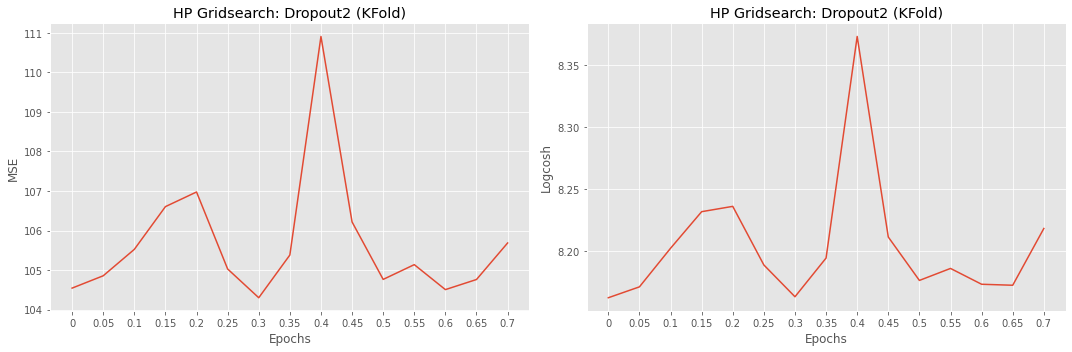

In [13]:
#metrics = metrics[:]
y1 = [i[0] for i in metrics if 'KFold' in i[3]]
y2 = [i[1] for i in metrics if 'KFold' in i[3]]
print('MSE scores:', y1)
print('Log cosh scores:', y2)
x = range(0,len(y1))
xtick_labels = [i[2] for i in metrics if 'KFold' in i[3]]

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(y1)
plt.xticks(x, xtick_labels)
plt.title('HP Gridsearch: Dropout2 (KFold)')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(y2)
plt.xticks(x, xtick_labels)
plt.title('HP Gridsearch: Dropout2 (KFold)')
plt.ylabel('Logcosh')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

In [14]:
import gc
gc.collect()

26708

Other n_steps (not 4) with the best hp
Predict one, predict all five
Cubic, quadratic linear regr  
Also, possible features:
* number of even numbers
* number of simple, fibbonachi numbers
* number of any other numbers - Types of integer numbers at https://en.wikipedia.org/wiki/List_of_types_of_numbers
* binary or any other base numbers?

## Appendix

### a) Searching for best number of units in LSTM

In [7]:
def run_cv( X_, y_, cv_folds, ts_flag=False, units=500, batch_size=32, epochs=6 ):
        
    print( f'Stacked_BiLSTM, units {units}, cv method {cv_folds.__str__()}' )
    print( f'                batch_size {batch_size}, num epochs {epochs}')
    verbose = 0
    score_per_fold, loss_per_fold = [], []

    fold_no = 1
    for train_idx, test_idx in cv_folds.split( X_ ):

        # Define and compile model
        model = stacked_BiLSTM( n_steps, n_features, units=units )

        print('\n', '='*100, '\n', sep='')
        print('Training in fold {} ...'.format( fold_no ))

        # Fit data to model
        if ts_flag:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=False,
                                 verbose=verbose )
        else:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=verbose )

        # Generate metrics
        scores = model.evaluate( X_[test_idx], y_[test_idx], verbose=verbose )
        print(f'Score in fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        score_per_fold.append( scores[1] )
        loss_per_fold.append(  scores[0] )

        # Increase fold number
        fold_no = fold_no + 1
        
    # Average scores
    average_loss  = round( np.mean(loss_per_fold), 4 )
    average_std   = round( np.std(loss_per_fold), 4 )
    average_score = round( np.mean(score_per_fold), 4)
    print( '\n', '='*100, sep='' )
    print( f'Average metrics for the run with {units} units, cv method {cv_folds.__str__()}, batch_size {batch_size} and number of epochs {epochs}')
    print('Per fold:')
    print( '{:>10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('', 1, 2, 3, 4, 5) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Loss',  *[ round(i, 4) for i in loss_per_fold  ] ) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Score', *[ round(i, 4) for i in score_per_fold ] ) )
    print( '='*100 )
    print(f'Average loss:  {average_loss}  +-{average_std}')
    print(f'Average score: {average_score}')
    print( '='*100 )
    
    return average_loss, average_std, average_score

In [ ]:
metrics = []
cv_engines = [ tscv, kf ]
num_units_list = [ 25, 50, 100, 200, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 7000 ]
for cv_engine in cv_engines:
    for num_units in num_units_list:
        
        ts_flag = 'TimeSeriesSplit' in cv_engine.__str__()
        if ts_flag:
            loss, std, score = run_cv( X, y, cv_engine, ts_flag, units=num_units)
        else:
            loss, std, score = run_cv( X_sh, y_sh, cv_engine, ts_flag, units=num_units)
                        
        metrics.append(( loss, score, num_units, cv_engine.__str__() ))
        print('metrics =', metrics)

### b) Searching for the best LR

In [9]:
def run_cv( X_, y_, cv_folds, ts_flag=False, learning_rate=0.001, batch_size=32, epochs=6 ):
        
    print( f'Stacked_BiLSTM, learning_rate {learning_rate}, cv method {cv_folds.__str__()}' )
    print( f'                batch_size {batch_size}, num epochs {epochs}')
    verbose = 0
    score_per_fold, loss_per_fold = [], []

    fold_no = 1
    for train_idx, test_idx in cv_folds.split( X_ ):

        # Define and compile model
        model = stacked_BiLSTM( n_steps, n_features, learning_rate=learning_rate )

        print('\n', '='*100, '\n', sep='')
        print('Training in fold {} ...'.format( fold_no ))

        # Fit data to model
        if ts_flag:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=False,
                                 verbose=verbose )
        else:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=verbose )

        # Generate metrics
        scores = model.evaluate( X_[test_idx], y_[test_idx], verbose=verbose )
        print(f'Score in fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        score_per_fold.append( scores[1] )
        loss_per_fold.append(  scores[0] )

        # Increase fold number
        fold_no = fold_no + 1
        
    # Average scores
    average_loss  = round( np.mean(loss_per_fold), 4 )
    average_std   = round( np.std(loss_per_fold), 4 )
    average_score = round( np.mean(score_per_fold), 4)
    print( '\n', '='*100, sep='' )
    print( f'Average metrics for the run with learning_rate {learning_rate}, cv method {cv_folds.__str__()}, batch_size {batch_size} and number of epochs {epochs}')
    print('Per fold:')
    print( '{:>10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('', 1, 2, 3, 4, 5) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Loss',  *[ round(i, 4) for i in loss_per_fold  ] ) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Score', *[ round(i, 4) for i in score_per_fold ] ) )
    print( '='*100 )
    print(f'Average loss:  {average_loss}  +-{average_std}')
    print(f'Average score: {average_score}')
    print( '='*100 )
    
    return average_loss, average_std, average_score

In [11]:
metrics = []
cv_engines = [ tscv, kf ]
lr_list = [ 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001, 0.0000005, 0.0000001 ]
for cv_engine in cv_engines:
    for lr_value in lr_list:
        
        ts_flag = 'TimeSeriesSplit' in cv_engine.__str__()
        if ts_flag:
            loss, std, score = run_cv( X, y, cv_engine, ts_flag, learning_rate=lr_value)
        else:
            loss, std, score = run_cv( X_sh, y_sh, cv_engine, ts_flag, learning_rate=lr_value)
                        
        metrics.append(( loss, score, lr_value, cv_engine.__str__() ))
        print('metrics =', metrics)

Stacked_BiLSTM, learning_rate 0.5, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5)
                batch_size 32, num epochs 6


Training in fold 1 ...
Score in fold 1: loss of nan; logcosh of nan


Training in fold 2 ...
Score in fold 2: loss of nan; logcosh of nan


Training in fold 3 ...
Score in fold 3: loss of nan; logcosh of nan


Training in fold 4 ...
Score in fold 4: loss of nan; logcosh of nan


Training in fold 5 ...
Score in fold 5: loss of nan; logcosh of nan

Average metrics for the run with learning_rate 0.5, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss         nan       nan       nan       nan       nan    
Score        nan       nan       nan       nan       nan    
Average loss:  nan  +-nan
Average score: nan
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)')]
Stacked_BiLSTM, learning_rate 0.1, cv method

Score in fold 2: loss of 106.45098876953125; logcosh of 8.203845024108887


Training in fold 3 ...
Score in fold 3: loss of 102.68387603759766; logcosh of 8.08864688873291


Training in fold 4 ...
Score in fold 4: loss of 108.08666229248047; logcosh of 8.32175350189209


Training in fold 5 ...
Score in fold 5: loss of 104.97423553466797; logcosh of 8.181370735168457

Average metrics for the run with learning_rate 0.005, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       109.4874  106.451   102.6839  108.0867  104.9742 
Score       8.3437    8.2038    8.0886    8.3218    8.1814  
Average loss:  106.3366  +-2.3749
Average score: 8.2279
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (139.6462, 9.1646, 0.05, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (10



Training in fold 1 ...
Score in fold 1: loss of 118.67880249023438; logcosh of 8.619885444641113


Training in fold 2 ...
Score in fold 2: loss of 108.08759307861328; logcosh of 8.212772369384766


Training in fold 3 ...
Score in fold 3: loss of 105.0899658203125; logcosh of 8.160932540893555


Training in fold 4 ...
Score in fold 4: loss of 106.84686279296875; logcosh of 8.265060424804688


Training in fold 5 ...
Score in fold 5: loss of 107.29280090332031; logcosh of 8.241986274719238

Average metrics for the run with learning_rate 5e-05, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       118.6788  108.0876   105.09   106.8469  107.2928 
Score       8.6199    8.2128    8.1609    8.2651    8.242   
Average loss:  109.1992  +-4.8405
Average score: 8.3001
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeri

Score in fold 2: loss of 435.4546813964844; logcosh of 17.59618377685547


Training in fold 3 ...
Score in fold 3: loss of 385.1512451171875; logcosh of 16.185821533203125


Training in fold 4 ...
Score in fold 4: loss of 393.0223083496094; logcosh of 16.356016159057617


Training in fold 5 ...
Score in fold 5: loss of 380.2164001464844; logcosh of 15.96224308013916

Average metrics for the run with learning_rate 1e-06, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       430.134   435.4547  385.1512  393.0223  380.2164 
Score      17.3171   17.5962   16.1858    16.356   15.9622  
Average loss:  404.7957  +-23.2837
Average score: 16.6835
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (139.6462, 9.1646, 0.05, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (



Training in fold 1 ...
Score in fold 1: loss of nan; logcosh of nan


Training in fold 2 ...
Score in fold 2: loss of nan; logcosh of nan


Training in fold 3 ...
Score in fold 3: loss of nan; logcosh of nan


Training in fold 4 ...
Score in fold 4: loss of nan; logcosh of nan


Training in fold 5 ...
Score in fold 5: loss of nan; logcosh of nan

Average metrics for the run with learning_rate 0.5, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss         nan       nan       nan       nan       nan    
Score        nan       nan       nan       nan       nan    
Average loss:  nan  +-nan
Average score: nan
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (139.6462, 9.1646, 0.05, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (106.0724, 8.2371, 0.01, 'TimeSerie



Training in fold 1 ...
Score in fold 1: loss of 107.66251373291016; logcosh of 8.328526496887207


Training in fold 2 ...
Score in fold 2: loss of 103.319091796875; logcosh of 8.066643714904785


Training in fold 3 ...
Score in fold 3: loss of 108.68247985839844; logcosh of 8.308956146240234


Training in fold 4 ...
Score in fold 4: loss of 106.15628051757812; logcosh of 8.262124061584473


Training in fold 5 ...
Score in fold 5: loss of 102.42111206054688; logcosh of 8.07724380493164

Average metrics for the run with learning_rate 0.01, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       107.6625  103.3191  108.6825  106.1563  102.4211 
Score       8.3285    8.0666    8.309     8.2621    8.0772  
Average loss:  105.6483  +-2.4233
Average score: 8.2087
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesS



Training in fold 1 ...
Score in fold 1: loss of 109.73755645751953; logcosh of 8.355958938598633


Training in fold 2 ...
Score in fold 2: loss of 103.0240707397461; logcosh of 8.03890323638916


Training in fold 3 ...
Score in fold 3: loss of 109.2991943359375; logcosh of 8.31516170501709


Training in fold 4 ...
Score in fold 4: loss of 112.63462829589844; logcosh of 8.4439058303833


Training in fold 5 ...
Score in fold 5: loss of 103.93792724609375; logcosh of 8.11541748046875

Average metrics for the run with learning_rate 0.0005, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       109.7376  103.0241  109.2992  112.6346  103.9379 
Score       8.356     8.0389    8.3152    8.4439    8.1154  
Average loss:  107.7267  +-3.6626
Average score: 8.2539
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesSpl



Training in fold 1 ...
Score in fold 1: loss of 116.29220581054688; logcosh of 8.583023071289062


Training in fold 2 ...
Score in fold 2: loss of 113.63667297363281; logcosh of 8.3953275680542


Training in fold 3 ...
Score in fold 3: loss of 108.47217559814453; logcosh of 8.24968433380127


Training in fold 4 ...
Score in fold 4: loss of 115.36315155029297; logcosh of 8.50232982635498


Training in fold 5 ...
Score in fold 5: loss of 111.49397277832031; logcosh of 8.330081939697266

Average metrics for the run with learning_rate 1e-05, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       116.2922  113.6367  108.4722  115.3632  111.494  
Score       8.583     8.3953    8.2497    8.5023    8.3301  
Average loss:  113.0516  +-2.8137
Average score: 8.4121
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesS

Score in fold 4: loss of 402.6661376953125; logcosh of 16.575836181640625


Training in fold 5 ...
Score in fold 5: loss of 400.27850341796875; logcosh of 16.622310638427734

Average metrics for the run with learning_rate 1e-06, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       381.9247  393.8374  399.1461  402.6661  400.2785 
Score      16.0069   16.4159   16.5438   16.5758   16.6223  
Average loss:  395.5706  +-7.4096
Average score: 16.4329
metrics = [(nan, nan, 0.5, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (nan, nan, 0.1, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (139.6462, 9.1646, 0.05, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (106.0724, 8.2371, 0.01, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (106.3366, 8.2279, 0.005, 'TimeSeriesSplit(max_train_size=1654, n_splits=5)'), (106.8924, 8.236, 0.001, 'TimeSeriesSpli

## Searching for best dropout rate

In [8]:
def run_cv( X_, y_, cv_folds, ts_flag=False, dropout=0.15, batch_size=32, epochs=6 ):
        
    print( f'Stacked_BiLSTM, dropout2 {dropout}, cv method {cv_folds.__str__()}' )
    print( f'                batch_size {batch_size}, num epochs {epochs}')
    verbose = 0
    score_per_fold, loss_per_fold = [], []

    fold_no = 1
    for train_idx, test_idx in cv_folds.split( X_ ):

        # Define and compile model
        model = stacked_BiLSTM( n_steps, n_features, dropout2=dropout )

        print('\n', '='*100, '\n', sep='')
        print('Training in fold {} ...'.format( fold_no ))

        # Fit data to model
        if ts_flag:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=False,
                                 verbose=verbose )
        else:
            history = model.fit( X_[train_idx], y_[train_idx],
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 shuffle=True,
                                 verbose=verbose )

        # Generate metrics
        scores = model.evaluate( X_[test_idx], y_[test_idx], verbose=verbose )
        print(f'Score in fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        score_per_fold.append( scores[1] )
        loss_per_fold.append(  scores[0] )

        # Increase fold number
        fold_no = fold_no + 1
        
    # Average scores
    average_loss  = round( np.mean(loss_per_fold), 4 )
    average_std   = round( np.std(loss_per_fold), 4 )
    average_score = round( np.mean(score_per_fold), 4)
    print( '\n', '='*100, sep='' )
    print( f'Average metrics for the run with dropout2 {dropout}, cv method {cv_folds.__str__()}, batch_size {batch_size} and number of epochs {epochs}')
    print('Per fold:')
    print( '{:>10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format('', 1, 2, 3, 4, 5) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Loss',  *[ round(i, 4) for i in loss_per_fold  ] ) )
    print( '{:<10}{:^10}{:^10}{:^10}{:^10}{:^10}'.format( 'Score', *[ round(i, 4) for i in score_per_fold ] ) )
    print( '='*100 )
    print(f'Average loss:  {average_loss}  +-{average_std}')
    print(f'Average score: {average_score}')
    print( '='*100 )
    
    return average_loss, average_std, average_score

In [9]:
metrics = []
cv_engines = [ kf, tscv ]
drpt_list = [ 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7 ]
for cv_engine in cv_engines:
    for dropout in drpt_list:
        
        ts_flag = 'TimeSeriesSplit' in cv_engine.__str__()
        if ts_flag:
            loss, std, score = run_cv( X, y, cv_engine, ts_flag, dropout=dropout)
        else:
            loss, std, score = run_cv( X_sh, y_sh, cv_engine, ts_flag, dropout=dropout)
                        
        metrics.append(( loss, score, dropout, cv_engine.__str__() ))
        print('metrics =', metrics)

Stacked_BiLSTM, dropout2 0, cv method KFold(n_splits=5, random_state=34, shuffle=True)
                batch_size 32, num epochs 6


Training in fold 1 ...
Score in fold 1: loss of 106.55168914794922; logcosh of 8.280599594116211


Training in fold 2 ...
Score in fold 2: loss of 102.69500732421875; logcosh of 8.040163040161133


Training in fold 3 ...
Score in fold 3: loss of 104.0307846069336; logcosh of 8.16988754272461


Training in fold 4 ...
Score in fold 4: loss of 107.66056060791016; logcosh of 8.276382446289062


Training in fold 5 ...
Score in fold 5: loss of 101.78812408447266; logcosh of 8.043107032775879

Average metrics for the run with dropout2 0, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       106.5517  102.695   104.0308  107.6606  101.7881 
Score       8.2806    8.0402    8.1699    8.2764    8.0431  
Average loss:  104.5452  +-2.237
Average



Training in fold 1 ...
Score in fold 1: loss of 112.94358825683594; logcosh of 8.469673156738281


Training in fold 2 ...
Score in fold 2: loss of 104.94447326660156; logcosh of 8.10914134979248


Training in fold 3 ...
Score in fold 3: loss of 104.78614807128906; logcosh of 8.196285247802734


Training in fold 4 ...
Score in fold 4: loss of 106.52212524414062; logcosh of 8.246725082397461


Training in fold 5 ...
Score in fold 5: loss of 105.6825180053711; logcosh of 8.157731056213379

Average metrics for the run with dropout2 0.2, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       112.9436  104.9445  104.7861  106.5221  105.6825 
Score       8.4697    8.1091    8.1963    8.2467    8.1577  
Average loss:  106.9758  +-3.0468
Average score: 8.2359
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFo



Training in fold 1 ...
Score in fold 1: loss of 121.13182830810547; logcosh of 8.698214530944824


Training in fold 2 ...
Score in fold 2: loss of 104.8266372680664; logcosh of 8.137709617614746


Training in fold 3 ...
Score in fold 3: loss of 105.01180267333984; logcosh of 8.20745849609375


Training in fold 4 ...
Score in fold 4: loss of 107.20008087158203; logcosh of 8.295973777770996


Training in fold 5 ...
Score in fold 5: loss of 116.3699951171875; logcosh of 8.527131080627441

Average metrics for the run with dropout2 0.4, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       121.1318  104.8266  105.0118  107.2001   116.37  
Score       8.6982    8.1377    8.2075    8.296     8.5271  
Average loss:  110.9081  +-6.6311
Average score: 8.3733
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 3 ...
Score in fold 3: loss of 104.77482604980469; logcosh of 8.1881685256958


Training in fold 4 ...
Score in fold 4: loss of 105.93824768066406; logcosh of 8.247111320495605


Training in fold 5 ...
Score in fold 5: loss of 103.96855163574219; logcosh of 8.111684799194336

Average metrics for the run with dropout2 0.55, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       107.2397  103.7718  104.7748  105.9382  103.9686 
Score       8.2928    8.0888    8.1882    8.2471    8.1117  
Average loss:  105.1386  +-1.298
Average score: 8.1857
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.5248, 8.202, 0.1, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.6055, 8.2316, 0.15, 'KFold(n_splits=5, random_state=34, shuffle=True

Score in fold 1: loss of 105.27674102783203; logcosh of 8.243785858154297


Training in fold 2 ...
Score in fold 2: loss of 104.1755142211914; logcosh of 8.121256828308105


Training in fold 3 ...
Score in fold 3: loss of 102.87623596191406; logcosh of 8.137253761291504


Training in fold 4 ...
Score in fold 4: loss of 108.15128326416016; logcosh of 8.323395729064941


Training in fold 5 ...
Score in fold 5: loss of 107.95166015625; logcosh of 8.264225959777832

Average metrics for the run with dropout2 0.7, cv method KFold(n_splits=5, random_state=34, shuffle=True), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       105.2767  104.1755  102.8762  108.1513  107.9517 
Score       8.2438    8.1213    8.1373    8.3234    8.2642  
Average loss:  105.6863  +-2.0763
Average score: 8.218
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=



Training in fold 1 ...
Score in fold 1: loss of 111.33051300048828; logcosh of 8.41871452331543


Training in fold 2 ...
Score in fold 2: loss of 104.37269592285156; logcosh of 8.149977684020996


Training in fold 3 ...
Score in fold 3: loss of 103.79759216308594; logcosh of 8.127901077270508


Training in fold 4 ...
Score in fold 4: loss of 108.43561553955078; logcosh of 8.339849472045898


Training in fold 5 ...
Score in fold 5: loss of 105.15776824951172; logcosh of 8.183481216430664

Average metrics for the run with dropout2 0.1, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.3305  104.3727  103.7976  108.4356  105.1578 
Score       8.4187     8.15     8.1279    8.3398    8.1835  
Average loss:  106.6188  +-2.851
Average score: 8.244
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 1 ...
Score in fold 1: loss of 111.46656036376953; logcosh of 8.370567321777344


Training in fold 2 ...
Score in fold 2: loss of 106.68963623046875; logcosh of 8.217764854431152


Training in fold 3 ...
Score in fold 3: loss of 102.3837890625; logcosh of 8.074373245239258


Training in fold 4 ...
Score in fold 4: loss of 108.65922546386719; logcosh of 8.34700870513916


Training in fold 5 ...
Score in fold 5: loss of 104.73695373535156; logcosh of 8.160039901733398

Average metrics for the run with dropout2 0.25, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.4666  106.6896  102.3838  108.6592  104.737  
Score       8.3706    8.2178    8.0744    8.347      8.16   
Average loss:  106.7872  +-3.1306
Average score: 8.234
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(



Training in fold 1 ...
Score in fold 1: loss of 111.61451721191406; logcosh of 8.427902221679688


Training in fold 2 ...
Score in fold 2: loss of 106.03932189941406; logcosh of 8.212669372558594


Training in fold 3 ...
Score in fold 3: loss of 103.44519805908203; logcosh of 8.118642807006836


Training in fold 4 ...
Score in fold 4: loss of 106.6817398071289; logcosh of 8.278470039367676


Training in fold 5 ...
Score in fold 5: loss of 104.50023651123047; logcosh of 8.1581392288208

Average metrics for the run with dropout2 0.4, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       111.6145  106.0393  103.4452  106.6817  104.5002 
Score       8.4279    8.2127    8.1186    8.2785    8.1581  
Average loss:  106.4562  +-2.8187
Average score: 8.2392
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFol



Training in fold 5 ...
Score in fold 5: loss of 105.2088623046875; logcosh of 8.186064720153809

Average metrics for the run with dropout2 0.5, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       109.2312   108.47   101.6906  106.7302  105.2089 
Score       8.3371    8.2688    8.0372    8.2799    8.1861  
Average loss:  106.2662  +-2.6802
Average score: 8.2218
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.5248, 8.202, 0.1, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.6055, 8.2316, 0.15, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (106.9758, 8.2359, 0.2, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (105.0289, 8.1885, 0.25, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.3018, 8.1628, 0.3, 'KFold(n_spli



Training in fold 1 ...
Score in fold 1: loss of 110.04083251953125; logcosh of 8.401792526245117


Training in fold 2 ...
Score in fold 2: loss of 104.72976684570312; logcosh of 8.158445358276367


Training in fold 3 ...
Score in fold 3: loss of 102.07359313964844; logcosh of 8.056126594543457


Training in fold 4 ...
Score in fold 4: loss of 107.82266235351562; logcosh of 8.308663368225098


Training in fold 5 ...
Score in fold 5: loss of 104.72434997558594; logcosh of 8.17288875579834

Average metrics for the run with dropout2 0.65, cv method TimeSeriesSplit(max_train_size=1654, n_splits=5), batch_size 32 and number of epochs 6
Per fold:
              1         2         3         4         5     
Loss       110.0408  104.7298  102.0736  107.8227  104.7243 
Score       8.4018    8.1584    8.0561    8.3087    8.1729  
Average loss:  105.8782  +-2.7653
Average score: 8.2196
metrics = [(104.5452, 8.162, 0, 'KFold(n_splits=5, random_state=34, shuffle=True)'), (104.857, 8.1708, 0.05, 'K